In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm
import pandas as pd
import numpy as np 
import os
import os.path as osp
import pandas as pd
from rdkit.Chem import rdmolops
from scipy.sparse import coo_matrix
from rdkit import Chem 
import random
import networkx as nx
import matplotlib.pyplot as plt
from captum.attr import Saliency, IntegratedGradients


In [2]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GraphConv,SAGEConv, GATConv, global_add_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data, download_url 
from torch_geometric.utils import to_networkx
import deepchem as dc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from collections import Counter, defaultdict
from scipy.stats import chi2_contingency


c:\Users\agavr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\agavr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


In [3]:
class DopingDataset(Dataset):
    def __init__(self, root, filename, atom_map, test=False, transform=None, pre_transform=None):
        self.test = test
        self.filename = filename
        self.atom_map = atom_map
        super(DopingDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename

    @property
    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        
    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol = Chem.MolFromSmiles(row["SMILES"])
            if mol is None:
                print(f"Invalid SMILES string at index {index}: {row['SMILES']}")
                continue
            try:
                f = featurizer._featurize(mol)
                if len(f.edge_index) == 0 or f.edge_features is None or f.edge_features.size == 0:
                    print(f"No bonds found in molecule at index {index}: {row['SMILES']}")
                    continue
                data = f.to_pyg_graph()
                data.y = self._get_label(row["Doping"])
                data.smiles = row["SMILES"]
                data.atom_indices = [self.atom_map.index(atom.GetSymbol()) for atom in mol.GetAtoms()]
                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'data_test_{index}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        try:
            if self.test:
                data = torch.load(os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
            else:
                data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))        
            return data
        except FileNotFoundError:
            print(f"File not found for index {idx}, skipping.")
            return None


In [4]:
def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']

    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)

    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    
    # Draw the graph
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='red')

    plt.show()

def to_molecule(data, atom_map):
    g = to_networkx(data, node_attrs=['x'])
   
    for u, node_data in g.nodes(data=True):
        atom_idx = data.atom_indices[u]
        node_data['name'] = atom_map[atom_idx]
        del node_data['x']
    return g

In [5]:
def analyze_dataset(dataset):
    total_nodes = 0
    total_edges = 0
    total_features = 0
    unique_nodes = set()
    num_graphs = len(dataset)
    
    for data in dataset:
        if data is not None:
            total_nodes += data.num_nodes
            total_edges += data.num_edges
            total_features += data.num_features
            unique_nodes.update(data.atom_indices)
    
    average_nodes = total_nodes / num_graphs if num_graphs > 0 else 0
    average_edges = total_edges / num_graphs if num_graphs > 0 else 0
    
    return {
        'total_nodes': total_nodes,
        'total_edges': total_edges,
        'total_features': total_features,
        'unique_nodes': len(unique_nodes),
        'average_nodes': average_nodes,
        'average_edges': average_edges,
    }

In [6]:
ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']

dataset = DopingDataset(root="data_filtered", filename="all_one.csv", atom_map=ATOM_MAP)

valid_data = [data for data in dataset if data is not None]

print(f"Number of valid data points: {len(valid_data)}")

#analyze_dataset(dataset)

Number of valid data points: 1366


In [7]:
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

SMILES formula: CC(C)N(CCC(C1=CC=CC=C1)C1=CC=CC=C1)C(C)C


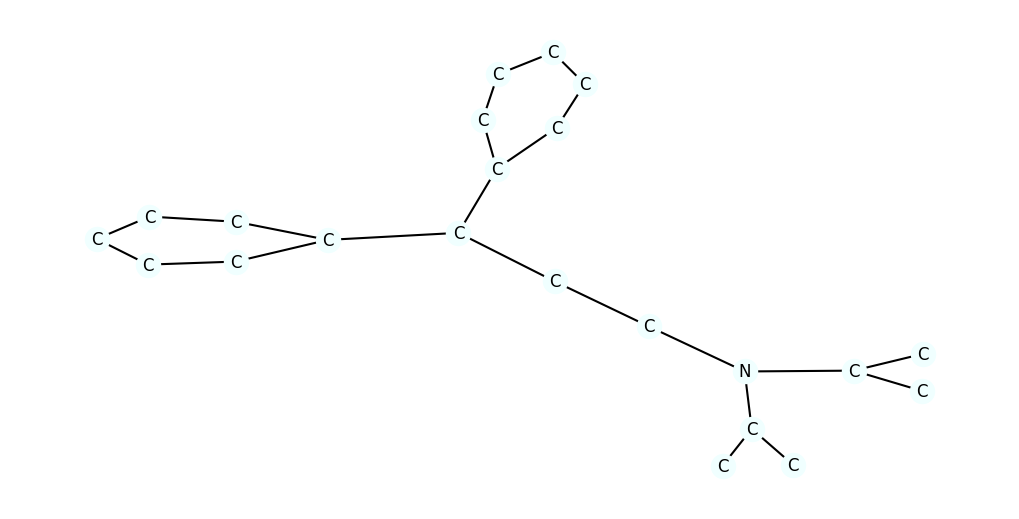

In [8]:
data_sample = random.choice(valid_data)
#data_sample = valid_data[20]
print(f"SMILES formula: {data_sample.smiles}")
mol = to_molecule(data_sample, ATOM_MAP)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

In [9]:
class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)


In [22]:
# SAGE Conv
class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = SAGEConv(num_features, dim)
        self.conv2 = SAGEConv(dim, dim)
        self.conv3 = SAGEConv(dim, dim)
        self.conv4 = SAGEConv(dim, dim)
        self.conv5 = SAGEConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        x = self.conv5(x, edge_index).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

In [10]:
# Custom DataLoader to skip missing files
class SafeDataLoader(DataLoader):
    def __iter__(self):
        for data in super().__iter__():
            if data is None:
                continue
            yield data

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)


In [13]:
# 80/20 training-test split
train_loader = SafeDataLoader(valid_data[:int(0.8*len(valid_data))], batch_size=32, shuffle=True)
test_loader = SafeDataLoader(valid_data[int(0.8*len(valid_data)):], batch_size=32, shuffle=False)

In [14]:
for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 0.7436, Train Acc: 0.5357, Test Acc: 0.5803
Epoch: 002, Loss: 0.6934, Train Acc: 0.5678, Test Acc: 0.5073
Epoch: 003, Loss: 0.6854, Train Acc: 0.5989, Test Acc: 0.6387
Epoch: 004, Loss: 0.6657, Train Acc: 0.6218, Test Acc: 0.6569
Epoch: 005, Loss: 0.6636, Train Acc: 0.6520, Test Acc: 0.6715
Epoch: 006, Loss: 0.6546, Train Acc: 0.5705, Test Acc: 0.6058
Epoch: 007, Loss: 0.6495, Train Acc: 0.6712, Test Acc: 0.6423
Epoch: 008, Loss: 0.6373, Train Acc: 0.6346, Test Acc: 0.6241
Epoch: 009, Loss: 0.6536, Train Acc: 0.6548, Test Acc: 0.5876
Epoch: 010, Loss: 0.6297, Train Acc: 0.6905, Test Acc: 0.6496
Epoch: 011, Loss: 0.6379, Train Acc: 0.6941, Test Acc: 0.6825
Epoch: 012, Loss: 0.6119, Train Acc: 0.6987, Test Acc: 0.6314
Epoch: 013, Loss: 0.6074, Train Acc: 0.7051, Test Acc: 0.7190
Epoch: 014, Loss: 0.6242, Train Acc: 0.6914, Test Acc: 0.7080
Epoch: 015, Loss: 0.6064, Train Acc: 0.7024, Test Acc: 0.7153
Epoch: 016, Loss: 0.6034, Train Acc: 0.7079, Test Acc: 0.7226
Epoch: 0

In [ ]:
###########################  Metrics  #############################
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def test(loader):
    model.eval()

    correct = 0
    all_preds = []
    all_labels = []

    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
        
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
    
    accuracy = correct / len(loader.dataset)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return accuracy, precision, recall, f1

# Training and testing the model
all_train_precisions = []
all_train_recalls = []
all_train_f1s = []

all_test_precisions = []
all_test_recalls = []
all_test_f1s = []

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc, train_precision, train_recall, train_f1 = test(train_loader)
    test_acc, test_precision, test_recall, test_f1 = test(test_loader)
    
    all_train_precisions.append(train_precision)
    all_train_recalls.append(train_recall)
    all_train_f1s.append(train_f1)
    
    all_test_precisions.append(test_precision)
    all_test_recalls.append(test_recall)
    all_test_f1s.append(test_f1)
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, '
          f'Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}, '
          f'Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}')

# Calculate average precision, recall, and F1 score
avg_train_precision = sum(all_train_precisions) / len(all_train_precisions)
avg_train_recall = sum(all_train_recalls) / len(all_train_recalls)
avg_train_f1 = sum(all_train_f1s) / len(all_train_f1s)

avg_test_precision = sum(all_test_precisions) / len(all_test_precisions)
avg_test_recall = sum(all_test_recalls) / len(all_test_recalls)
avg_test_f1 = sum(all_test_f1s) / len(all_test_f1s)

print(f'Average Train Precision: {avg_train_precision:.4f}, Average Train Recall: {avg_train_recall:.4f}, Average Train F1: {avg_train_f1:.4f}')
print(f'Average Test Precision: {avg_test_precision:.4f}, Average Test Recall: {avg_test_recall:.4f}, Average Test F1: {avg_test_f1:.4f}')


In [53]:
# Training function
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def test(loader):
    model.eval()

    correct = 0
    all_preds = []
    all_labels = []
    misclassified_samples = []

    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

        # Identify misclassified samples
        misclassified = pred != data.y
        if any(misclassified):
            misclassified_indices = misclassified.nonzero(as_tuple=True)[0]
            if data.x.dim() > 2:
                misclassified_data = (data.x.view(data.batch_size, -1)[misclassified_indices], 
                                      data.y[misclassified_indices], 
                                      pred[misclassified_indices])
            else:
                misclassified_data = (data.x[misclassified_indices], 
                                      data.y[misclassified_indices], 
                                      pred[misclassified_indices])
            misclassified_samples.append(misclassified_data)

            # Print details of misclassified samples
            print("Misclassified Sample Details:")
            for index in misclassified_indices:
                print(f"Index: {index}, True Label: {data.y[index].item()}, Predicted Label: {pred[index].item()}")
                print(f"Features: {data.x[index] if data.x.dim() == 1 else data.x.view(-1)[index]}")

    accuracy = correct / len(loader.dataset)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return accuracy, precision, recall, f1, misclassified_samples

all_train_precisions = []
all_train_recalls = []
all_train_f1s = []

all_test_precisions = []
all_test_recalls = []
all_test_f1s = []

for epoch in range(1, 101):
    loss = train(epoch)

    train_acc, train_precision, train_recall, train_f1, train_misclassified = test(train_loader)
    test_acc, test_precision, test_recall, test_f1, test_misclassified = test(test_loader)
    
    all_train_precisions.append(train_precision)
    all_train_recalls.append(train_recall)
    all_train_f1s.append(train_f1)
    
    all_test_precisions.append(test_precision)
    all_test_recalls.append(test_recall)
    all_test_f1s.append(test_f1)
    
    # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
    #       f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, '
    #       f'Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}, '
    #       f'Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}')

# Calculate average precision, recall, and F1 score
avg_train_precision = sum(all_train_precisions) / len(all_train_precisions)
avg_train_recall = sum(all_train_recalls) / len(all_train_recalls)
avg_train_f1 = sum(all_train_f1s) / len(all_train_f1s)

avg_test_precision = sum(all_test_precisions) / len(all_test_precisions)
avg_test_recall = sum(all_test_recalls) / len(all_test_recalls)
avg_test_f1 = sum(all_test_f1s) / len(all_test_f1s)

print(f'Average Train Precision: {avg_train_precision:.4f}, Average Train Recall: {avg_train_recall:.4f}, Average Train F1: {avg_train_f1:.4f}')
print(f'Average Test Precision: {avg_test_precision:.4f}, Average Test Recall: {avg_test_recall:.4f}, Average Test F1: {avg_test_f1:.4f}')


Misclassified Sample Details:
Index: 1, True Label: 0, Predicted Label: 1
Features: 0.0
Index: 14, True Label: 0, Predicted Label: 1
Features: 0.0
Index: 23, True Label: 1, Predicted Label: 0
Features: 0.0
Index: 24, True Label: 1, Predicted Label: 0
Features: 0.0
Misclassified Sample Details:
Index: 2, True Label: 0, Predicted Label: 1
Features: 0.0
Misclassified Sample Details:
Index: 3, True Label: 0, Predicted Label: 1
Features: 0.0
Index: 27, True Label: 0, Predicted Label: 1
Features: 0.0
Misclassified Sample Details:
Index: 11, True Label: 1, Predicted Label: 0
Features: 0.0
Misclassified Sample Details:
Index: 14, True Label: 0, Predicted Label: 1
Features: 1.0
Index: 15, True Label: 1, Predicted Label: 0
Features: 0.0
Index: 25, True Label: 0, Predicted Label: 1
Features: 0.0
Misclassified Sample Details:
Index: 11, True Label: 0, Predicted Label: 1
Features: 0.0
Index: 12, True Label: 0, Predicted Label: 1
Features: 0.0
Index: 13, True Label: 0, Predicted Label: 1
Features: 1

In [54]:
def test(loader):
    model.eval()

    correct = 0
    all_preds = []
    all_labels = []
    misclassified_samples = []
    misclassification_counts = {}  # Dictionary to count misclassified indexes

    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

        # Identify misclassified samples
        misclassified = pred != data.y
        if any(misclassified):
            misclassified_indices = misclassified.nonzero(as_tuple=True)[0]
            for index in misclassified_indices:
                actual_index = index.item()
                # Update count in misclassification_counts
                if actual_index in misclassification_counts:
                    misclassification_counts[actual_index] += 1
                else:
                    misclassification_counts[actual_index] = 1

            # Collect detailed misclassified data
            if data.x.dim() > 2:
                misclassified_data = (data.x.view(data.batch_size, -1)[misclassified_indices], 
                                      data.y[misclassified_indices], 
                                      pred[misclassified_indices])
            else:
                misclassified_data = (data.x[misclassified_indices], 
                                      data.y[misclassified_indices], 
                                      pred[misclassified_indices])
            misclassified_samples.append(misclassified_data)

    accuracy = correct / len(loader.dataset)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return accuracy, precision, recall, f1, misclassified_samples, misclassification_counts


In [55]:
from collections import defaultdict

overall_misclassification_counts = defaultdict(int)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc, train_precision, train_recall, train_f1, train_misclassified, train_counts = test(train_loader)
    test_acc, test_precision, test_recall, test_f1, test_misclassified, test_counts = test(test_loader)
    
    # Aggregate misclassification counts
    for index, count in train_counts.items():
        overall_misclassification_counts[index] += count
    for index, count in test_counts.items():
        overall_misclassification_counts[index] += count
    
    # Usual logging
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, '
          f'Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}, '
          f'Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}')

# Find most frequently misclassified indexes
most_common_misclassified = sorted(overall_misclassification_counts.items(), key=lambda x: x[1], reverse=True)

# Print top 5 most frequently misclassified indexes
print("Most frequently misclassified indexes and their counts:")
for index, count in most_common_misclassified[:5]:
    print(f"Index: {index}, Count: {count}")


Epoch: 001, Loss: 0.0925, Train Acc: 0.9652, Test Acc: 0.7920, Train Precision: 0.9656, Test Precision: 0.7868, Train Recall: 0.9645, Test Recall: 0.7940
Epoch: 002, Loss: 0.1047, Train Acc: 0.9579, Test Acc: 0.7737, Train Precision: 0.9584, Test Precision: 0.7681, Train Recall: 0.9570, Test Recall: 0.7745
Epoch: 003, Loss: 0.0999, Train Acc: 0.9707, Test Acc: 0.7737, Train Precision: 0.9711, Test Precision: 0.7695, Train Recall: 0.9700, Test Recall: 0.7771
Epoch: 004, Loss: 0.0980, Train Acc: 0.9643, Test Acc: 0.7810, Train Precision: 0.9674, Test Precision: 0.7745, Train Recall: 0.9621, Test Recall: 0.7794
Epoch: 005, Loss: 0.0991, Train Acc: 0.9689, Test Acc: 0.7847, Train Precision: 0.9693, Test Precision: 0.7794, Train Recall: 0.9682, Test Recall: 0.7864
Epoch: 006, Loss: 0.1134, Train Acc: 0.9597, Test Acc: 0.7920, Train Precision: 0.9608, Test Precision: 0.7858, Train Recall: 0.9584, Test Recall: 0.7913
Epoch: 007, Loss: 0.1052, Train Acc: 0.9707, Test Acc: 0.7810, Train Precisi

In [116]:
class Net(torch.nn.Module):
    def __init__(self, dim, heads=8):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GATConv(num_features, dim, heads=heads, concat=True)
        self.conv2 = GATConv(dim * heads, dim, heads=heads, concat=True)
        self.conv3 = GATConv(dim * heads, dim, heads=heads, concat=True)
        self.conv4 = GATConv(dim * heads, dim, heads=heads, concat=True)
        self.conv5 = GATConv(dim * heads, dim, heads=heads, concat=False)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        x = self.conv5(x, edge_index).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

def train(loader, model, optimizer):
    model.train()
    loss_all = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(loader.dataset)

def test(loader, model):
    model.eval()
    all_preds = []
    all_labels = []

    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return precision, recall, f1

# Setting up the device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [117]:
# 5 - fold 
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(valid_data)):
    print(f'Fold {fold+1}')
    
    train_dataset = [valid_data[i] for i in train_idx]
    test_dataset = [valid_data[i] for i in test_idx]
    
    train_loader = SafeDataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = SafeDataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # model = Net(dim=32, heads=8).to(device)
    model = Net(dim=32).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(1, 101):
        loss = train(train_loader, model, optimizer)
        train_precision, train_recall, train_f1 = test(train_loader, model)
        test_precision, test_recall, test_f1 = test(test_loader, model)
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}')
    
    fold_results.append((train_precision, train_recall, train_f1, test_precision, test_recall, test_f1))

Fold 1
Epoch: 010, Loss: 0.6323, Train F1: 0.5851, Test F1: 0.5270
Epoch: 020, Loss: 0.6189, Train F1: 0.7104, Test F1: 0.6569
Epoch: 030, Loss: 0.5378, Train F1: 0.7054, Test F1: 0.6465
Epoch: 040, Loss: 0.4777, Train F1: 0.8022, Test F1: 0.7117
Epoch: 050, Loss: 0.4411, Train F1: 0.8340, Test F1: 0.6887
Epoch: 060, Loss: 0.3558, Train F1: 0.8810, Test F1: 0.7166
Epoch: 070, Loss: 0.3246, Train F1: 0.8831, Test F1: 0.7148
Epoch: 080, Loss: 0.3047, Train F1: 0.8931, Test F1: 0.7131
Epoch: 090, Loss: 0.2329, Train F1: 0.9157, Test F1: 0.7085
Epoch: 100, Loss: 0.2289, Train F1: 0.9208, Test F1: 0.7240
Fold 2
Epoch: 010, Loss: 0.6286, Train F1: 0.6600, Test F1: 0.6004
Epoch: 020, Loss: 0.5663, Train F1: 0.7308, Test F1: 0.6005
Epoch: 030, Loss: 0.5173, Train F1: 0.7811, Test F1: 0.6675
Epoch: 040, Loss: 0.4351, Train F1: 0.7791, Test F1: 0.6315
Epoch: 050, Loss: 0.3999, Train F1: 0.8299, Test F1: 0.7254
Epoch: 060, Loss: 0.3577, Train F1: 0.8490, Test F1: 0.6846
Epoch: 070, Loss: 0.3140, 

In [118]:
# Aggregate results
avg_train_precision = sum([res[0] for res in fold_results]) / len(fold_results)
avg_train_recall = sum([res[1] for res in fold_results]) / len(fold_results)
avg_train_f1 = sum([res[2] for res in fold_results]) / len(fold_results)

avg_test_precision = sum([res[3] for res in fold_results]) / len(fold_results)
avg_test_recall = sum([res[4] for res in fold_results]) / len(fold_results)
avg_test_f1 = sum([res[5] for res in fold_results]) / len(fold_results)

print(f'Average Train Precision: {avg_train_precision:.4f}, Average Train Recall: {avg_train_recall:.4f}, Average Train F1: {avg_train_f1:.4f}')
print(f'Average Test Precision: {avg_test_precision:.4f}, Average Test Recall: {avg_test_recall:.4f}, Average Test F1: {avg_test_f1:.4f}')

Average Train Precision: 0.9269, Average Train Recall: 0.9215, Average Train F1: 0.9222
Average Test Precision: 0.7425, Average Test Recall: 0.7370, Average Test F1: 0.7280


In [15]:
def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out
def explain(method, data, target=1):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zearo
        edge_mask = edge_mask / edge_mask.max()
    
    # Get influential edges
    edge_influence = [(u.item(), v.item(), val) for val, u, v in zip(edge_mask, *data.edge_index)]
    #edge_influence = [(u.item(), v.item(), val) for val, u, v in zip(edge_mask, data.edge_index[0], data.edge_index[1])]
    edge_influence.sort(key=lambda x: x[2], reverse=True)
    influential_edges = edge_influence[:10]  # Top 10 influential edges
    
    return edge_mask, influential_edges


In [16]:
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, (u, v) in zip(edge_mask, data.edge_index.t().tolist()):
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

In [ ]:
def aggregate_edge_importance(dataset):
    edge_importance_prohibited = Counter()
    edge_importance_non_prohibited = Counter()

    for data in dataset:  # Assuming 'dataset' contains all your data
        label = data.y.item()  # Assuming label is stored in data.y
        for method in ['ig', 'saliency']:
            _, influential_edges, _ = explain(method, data)  # Correct unpacking of returned values
            if label == 1:  # Prohibited
                for u, v, _ in influential_edges:
                    edge_importance_prohibited[(u, v)] += 1
            else:  # Non-prohibited
                for u, v, _ in influential_edges:
                    edge_importance_non_prohibited[(u, v)] += 1

    return edge_importance_prohibited, edge_importance_non_prohibited

def perform_chi_square_test(edge_importance_prohibited, edge_importance_non_prohibited):
    edges = set(edge_importance_prohibited.keys()).union(set(edge_importance_non_prohibited.keys()))
    contingency_table = []
    for edge in edges:
        prohibited_count = edge_importance_prohibited[edge]
        non_prohibited_count = edge_importance_non_prohibited[edge]
        contingency_table.append([prohibited_count, non_prohibited_count])

    # Perform Chi-Square test
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p


edge_importance_prohibited, edge_importance_non_prohibited = aggregate_edge_importance(dataset)
chi2_stat, p_value = perform_chi_square_test(edge_importance_prohibited, edge_importance_non_prohibited)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")

In [73]:
# Correcting the example usage to handle the potential return of None:
try:
    (edge_importance_prohibited_ig, edge_importance_non_prohibited_ig,
     edge_importance_prohibited_saliency, edge_importance_non_prohibited_saliency) = aggregate_edge_importance(dataset)

    chi2_stat_ig, p_value_ig = perform_chi_square_test(edge_importance_prohibited_ig, edge_importance_non_prohibited_ig)
    chi2_stat_saliency, p_value_saliency = perform_chi_square_test(edge_importance_prohibited_saliency, edge_importance_non_prohibited_saliency)

    print("Integrated Gradients:")
    print(f"Chi-Square Statistic: {chi2_stat_ig}")
    print(f"P-Value: {p_value_ig}")

    print("\nSaliency:")
    print(f"Chi-Square Statistic: {chi2_stat_saliency}")
    print(f"P-Value: {p_value_saliency}")

except TypeError as e:
    print(f"Error: {str(e)}")


Integrated Gradients:
Chi-Square Statistic: 1651.267785718696
P-Value: 7.767141965569152e-17

Saliency:
Chi-Square Statistic: 1821.7156542971506
P-Value: 2.0987469007227781e-22


Chosen molecule SMILES: OC(CCN1CCCC1)(C1CCCCC1)C1=CC=CC=C1
Integrated Gradients Method - Influential Edges:
Edge (3, 2) with importance 1.0000 connecting C-C
Edge (2, 3) with importance 0.9529 connecting C-C
Edge (6, 5) with importance 0.9075 connecting C-C
Edge (7, 8) with importance 0.9075 connecting C-C
Edge (12, 11) with importance 0.8997 connecting C-C
Edge (12, 13) with importance 0.8997 connecting C-C
Edge (11, 12) with importance 0.8895 connecting C-C
Edge (13, 12) with importance 0.8895 connecting C-C
Edge (5, 6) with importance 0.8890 connecting C-C
Edge (8, 7) with importance 0.8890 connecting C-C


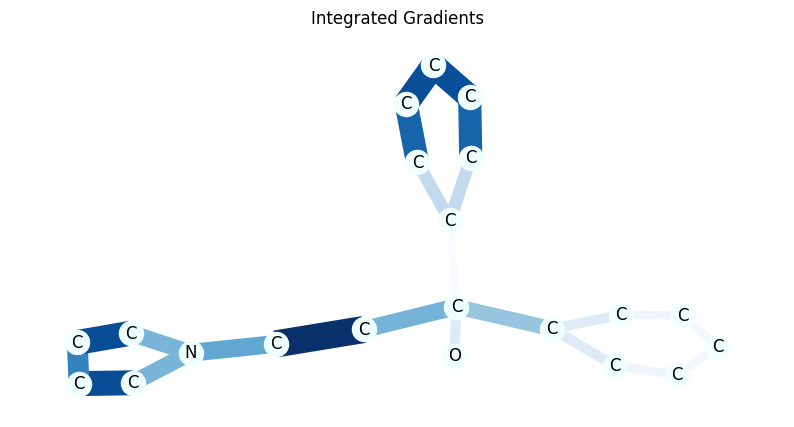

Saliency Method - Influential Edges:
Edge (9, 1) with importance 1.0000 connecting C-C
Edge (3, 2) with importance 0.9972 connecting C-C
Edge (10, 9) with importance 0.8162 connecting C-C
Edge (14, 9) with importance 0.8162 connecting C-C
Edge (6, 5) with importance 0.7723 connecting C-C
Edge (7, 8) with importance 0.7723 connecting C-C
Edge (11, 10) with importance 0.7530 connecting C-C
Edge (13, 14) with importance 0.7530 connecting C-C
Edge (1, 9) with importance 0.6920 connecting C-C
Edge (0, 1) with importance 0.6310 connecting O-C


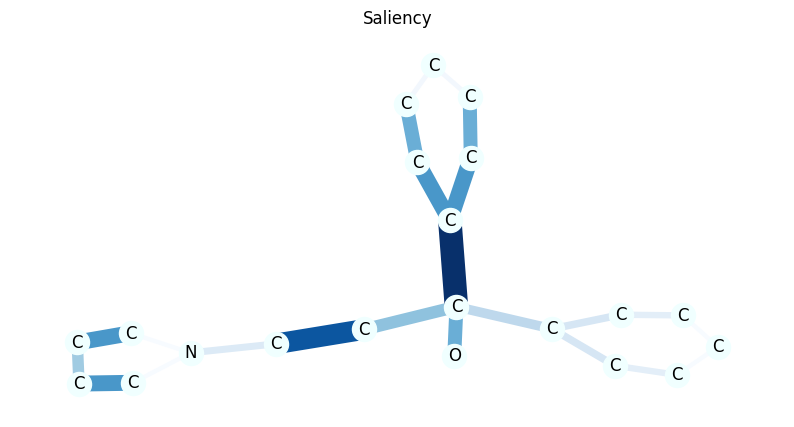

In [23]:

data = random.choice([t for t in test_dataset if not t.y.item()])
#data = valid_data[20]
print(f"Chosen molecule SMILES: {data.smiles}")

mol = to_molecule(data, ATOM_MAP)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask, influential_edges = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    # Print influential edges and nodes
    print(f"{title} Method - Influential Edges:")
    for u, v, val in influential_edges:
        atom_u = mol.nodes[u]['name']
        atom_v = mol.nodes[v]['name']
        print(f"Edge ({u}, {v}) with importance {val:.4f} connecting {atom_u}-{atom_v}")

  
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

In [33]:
def evaluate_edge_deletion(model, data, edge_mask, top_k=10):
    model.eval()
    original_pred = model(data.x, data.edge_index, torch.zeros(data.x.shape[0], dtype=int).to(device))
    
    # Get top-k influential edges
    top_edges = edge_mask.argsort()[-top_k:]
    new_edge_index = torch.tensor([
        [u for i, (u, v) in enumerate(zip(data.edge_index[0], data.edge_index[1])) if i not in top_edges],
        [v for i, (u, v) in enumerate(zip(data.edge_index[0], data.edge_index[1])) if i not in top_edges]
    ]).to(device)
    
    new_pred = model(data.x, new_edge_index, torch.zeros(data.x.shape[0], dtype=int).to(device))
    performance_drop = torch.abs(original_pred - new_pred).mean().item()
    
    return performance_drop

# Example usage
edge_mask_ig, _, _ = explain('ig', data, target=1)
edge_mask_saliency, _, _ = explain('saliency', data, target=1)

ig_performance_drop = evaluate_edge_deletion(model, data, edge_mask_ig)
saliency_performance_drop = evaluate_edge_deletion(model, data, edge_mask_saliency)

print(f"Performance drop after removing top edges (IG): {ig_performance_drop}")
print(f"Performance drop after removing top edges (Saliency): {saliency_performance_drop}")


Performance drop after removing top edges (IG): 22.333675384521484
Performance drop after removing top edges (Saliency): 11.922720909118652


Performance drop after removing top edges (IG): 5.906665802001953
Edges removed (IG):
Edge (7, 6)
Edge (1, 0)
Edge (0, 1)
Edge (5, 6)
Edge (5, 4)
Performance drop after removing top edges (Saliency): 6.7993364334106445
Edges removed (Saliency):
Edge (6, 5)
Edge (3, 4)
Edge (7, 6)
Edge (5, 6)
Edge (5, 4)


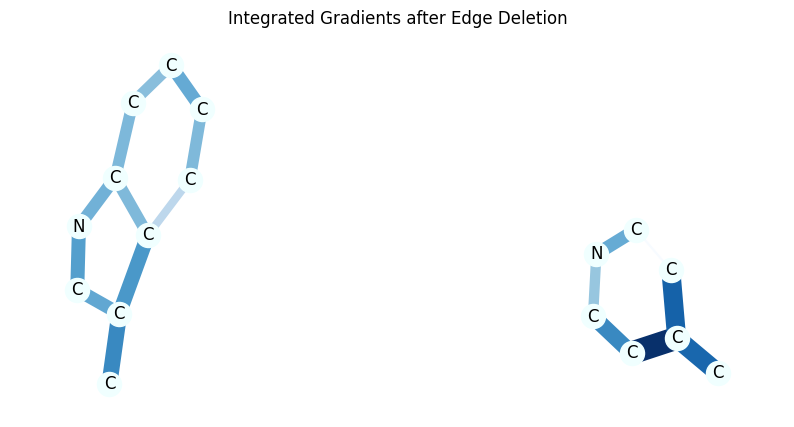

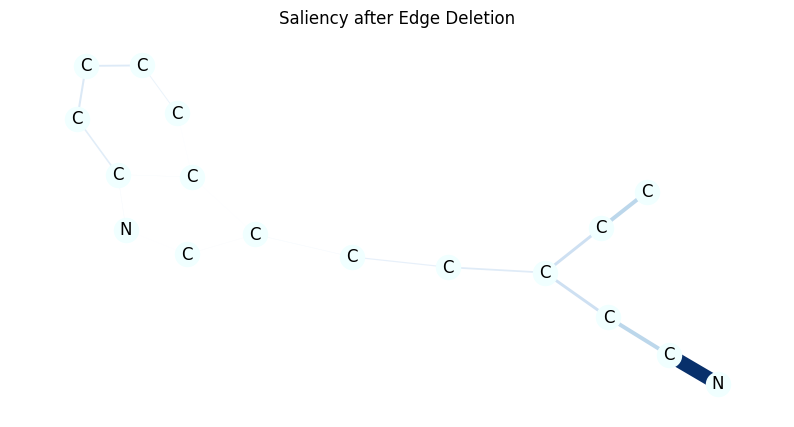

In [26]:
def evaluate_edge_deletion(model, data, edge_mask, top_k=5):
    model.eval()
    original_pred = model(data.x, data.edge_index, torch.zeros(data.x.shape[0], dtype=int).to(device))
    
    # Get top-k influential edges
    top_edge_indices = edge_mask.argsort()[-top_k:]
    top_edges = [(data.edge_index[0, i].item(), data.edge_index[1, i].item()) for i in top_edge_indices]
    
    # Create new edge index without the top-k edges
    new_edge_index = torch.tensor([
        [u for i, (u, v) in enumerate(zip(data.edge_index[0], data.edge_index[1])) if i not in top_edge_indices],
        [v for i, (u, v) in enumerate(zip(data.edge_index[0], data.edge_index[1])) if i not in top_edge_indices]
    ]).to(device)
    
    new_pred = model(data.x, new_edge_index, torch.zeros(data.x.shape[0], dtype=int).to(device))
    performance_drop = torch.abs(original_pred - new_pred).mean().item()
    
    # Create new data object with updated edge index
    new_data = data.clone()
    new_data.edge_index = new_edge_index
    
    return performance_drop, top_edges, new_data

# Example usage
edge_mask_ig, _, _ = explain('ig', data, target=1)
edge_mask_saliency, _, _ = explain('saliency', data, target=1)

ig_performance_drop, ig_top_edges, new_data_ig = evaluate_edge_deletion(model, data, edge_mask_ig)
saliency_performance_drop, saliency_top_edges, new_data_saliency = evaluate_edge_deletion(model, data, edge_mask_saliency)

print(f"Performance drop after removing top edges (IG): {ig_performance_drop}")
print("Edges removed (IG):")
for u, v in ig_top_edges:
    print(f"Edge ({u}, {v})")

print(f"Performance drop after removing top edges (Saliency): {saliency_performance_drop}")
print("Edges removed (Saliency):")
for u, v in saliency_top_edges:
    print(f"Edge ({u}, {v})")

# Generate new explanations on modified graphs
new_edge_mask_ig, _, _ = explain('ig', new_data_ig, target=1)
new_edge_mask_saliency, _, _ = explain('saliency', new_data_saliency, target=1)

# Visualization function
def visualize_explanation(data, edge_mask, title):
    mol = to_molecule(data, ATOM_MAP)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

# Visualize new explanations
visualize_explanation(new_data_ig, new_edge_mask_ig, "Integrated Gradients after Edge Deletion")
visualize_explanation(new_data_saliency, new_edge_mask_saliency, "Saliency after Edge Deletion")


Original prediction: tensor([[-2.4569, -0.0896]], grad_fn=<LogSoftmaxBackward0>)
New prediction after removing edges: tensor([[  0.0000, -35.9598]], grad_fn=<LogSoftmaxBackward0>)
Original prediction: tensor([[-2.4569, -0.0896]], grad_fn=<LogSoftmaxBackward0>)
New prediction after removing edges: tensor([[-1.5258e-04, -8.7879e+00]], grad_fn=<LogSoftmaxBackward0>)
Performance drop after removing top edges (IG): 19.16358184814453
Edges removed (IG):
Edge (5, 6)
Edge (9, 11)
Edge (1, 0)
Edge (14, 15)
Edge (11, 12)
Performance drop after removing top edges (Saliency): 5.577548980712891
Edges removed (Saliency):
Edge (5, 6)
Edge (15, 14)
Edge (4, 5)
Edge (13, 4)
Edge (14, 13)


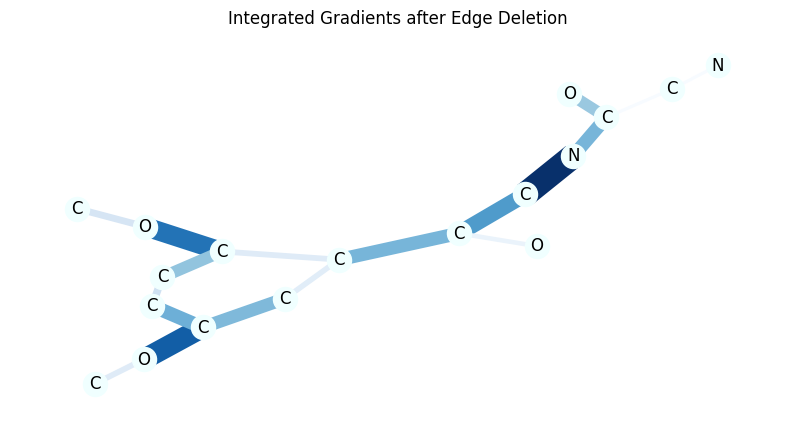

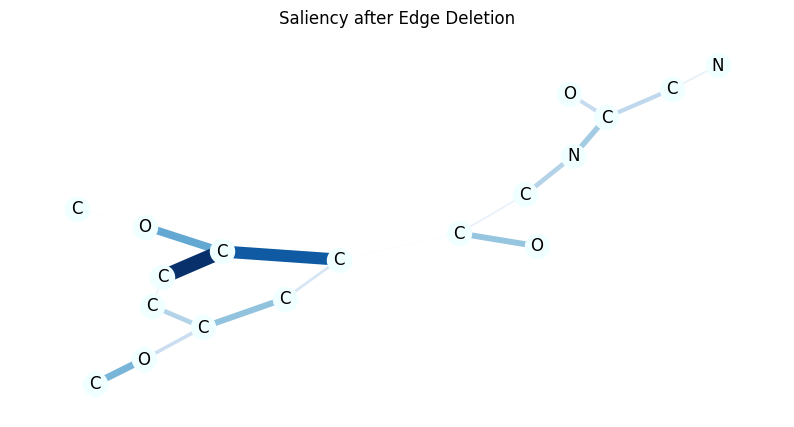

In [34]:
def evaluate_edge_deletion(model, data, edge_mask, top_k=5):
    model.eval()
    
    original_pred = model(data.x, data.edge_index, torch.zeros(data.x.shape[0], dtype=int).to(device))
    
    # Get top-k influential edges
    top_edge_indices = edge_mask.argsort()[-top_k:]
    top_edges = [(data.edge_index[0, i].item(), data.edge_index[1, i].item()) for i in top_edge_indices]
    
    # Create new edge index without the top-k edges
    new_edge_index = torch.tensor([
        [u for i, (u, v) in enumerate(zip(data.edge_index[0], data.edge_index[1])) if i not in top_edge_indices],
        [v for i, (u, v) in enumerate(zip(data.edge_index[0], data.edge_index[1])) if i not in top_edge_indices]
    ]).to(device)
    
    # Make new prediction on the modified graph
    new_pred = model(data.x, new_edge_index, torch.zeros(data.x.shape[0], dtype=int).to(device))
    
    # Calculate performance drop (assuming binary classification)
    performance_drop = torch.abs(original_pred - new_pred).mean().item()

    print(f"Original prediction: {original_pred}")
    print(f"New prediction after removing edges: {new_pred}")
    
    # Create new data object with updated edge index
    new_data = data.clone()
    new_data.edge_index = new_edge_index
    
    return performance_drop, top_edges, new_data

edge_mask_ig, _, _ = explain('ig', data, target=1)
edge_mask_saliency, _, _ = explain('saliency', data, target=1)

ig_performance_drop, ig_top_edges, new_data_ig = evaluate_edge_deletion(model, data, edge_mask_ig)
saliency_performance_drop, saliency_top_edges, new_data_saliency = evaluate_edge_deletion(model, data, edge_mask_saliency)

print(f"Performance drop after removing top edges (IG): {ig_performance_drop}")
print("Edges removed (IG):")
for u, v in ig_top_edges:
    print(f"Edge ({u}, {v})")

print(f"Performance drop after removing top edges (Saliency): {saliency_performance_drop}")
print("Edges removed (Saliency):")
for u, v in saliency_top_edges:
    print(f"Edge ({u}, {v})")

# Generate new explanations on modified graphs
new_edge_mask_ig, _, _ = explain('ig', new_data_ig, target=1)
new_edge_mask_saliency, _, _ = explain('saliency', new_data_saliency, target=1)

# Visualization function
def visualize_explanation(data, edge_mask, title):
    mol = to_molecule(data, ATOM_MAP)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

# Visualize new explanations
visualize_explanation(new_data_ig, new_edge_mask_ig, "Integrated Gradients after Edge Deletion")
visualize_explanation(new_data_saliency, new_edge_mask_saliency, "Saliency after Edge Deletion")


In [15]:
def evaluate_edge_deletion(model, data, edge_mask, top_k=10):
    model.eval()
    
    # Make original prediction
    original_pred = model(data.x, data.edge_index, torch.zeros(data.x.shape[0], dtype=int).to(device))
    
    # Get top-k influential edges
    top_edge_indices = edge_mask.argsort()[-top_k:]
    top_edges = [(data.edge_index[0, i].item(), data.edge_index[1, i].item()) for i in top_edge_indices]
    
    # Create new edge index without the top-k edges
    new_edge_index = torch.tensor([
        [u for i, (u, v) in enumerate(zip(data.edge_index[0], data.edge_index[1])) if i not in top_edge_indices],
        [v for i, (u, v) in enumerate(zip(data.edge_index[0], data.edge_index[1])) if i not in top_edge_indices]
    ], dtype=torch.long).to(device)  # Ensure the dtype is torch.long
    
    # Make new prediction on the modified graph
    new_pred = model(data.x, new_edge_index, torch.zeros(data.x.shape[0], dtype=int).to(device))
    
    # Calculate performance drop (assuming binary classification)
    performance_drop = torch.abs(original_pred - new_pred).mean().item()
    
    return performance_drop

def explain_and_evaluate(model, data, top_k=10):
    edge_mask_ig, _, _ = explain('ig', data, target=1)
    edge_mask_saliency, _, _ = explain('saliency', data, target=1)
    
    ig_performance_drop = evaluate_edge_deletion(model, data, edge_mask_ig, top_k)
    saliency_performance_drop = evaluate_edge_deletion(model, data, edge_mask_saliency, top_k)
    
    return ig_performance_drop, saliency_performance_drop

# Iterate over the dataset and compute average performance drop
def compute_average_performance_drop(model, dataset, top_k=10):
    ig_performance_drops = []
    saliency_performance_drops = []

    for data in dataset:
        ig_drop, saliency_drop = explain_and_evaluate(model, data, top_k)
        ig_performance_drops.append(ig_drop)
        saliency_performance_drops.append(saliency_drop)
    
    avg_ig_drop = sum(ig_performance_drops) / len(ig_performance_drops)
    avg_saliency_drop = sum(saliency_performance_drops) / len(saliency_performance_drops)
    
    return avg_ig_drop, avg_saliency_drop

avg_ig_drop, avg_saliency_drop = compute_average_performance_drop(model, dataset, top_k=5)

print(f"Average performance drop (IG): {avg_ig_drop}")
print(f"Average performance drop (Saliency): {avg_saliency_drop}")

Average performance drop (IG): 2.331082150262356
Average performance drop (Saliency): 2.3098439630414163


In [21]:
from typing import Tuple
from torch_geometric.explain.config import ExplanationType, ModelMode

def fidelity(explainer, explanation) -> Tuple[float, float]:
    if explainer.model_config.mode == ModelMode.regression:
        raise ValueError("Fidelity not defined for 'regression' models")

    node_mask = explanation.get('node_mask')
    edge_mask = explanation.get('edge_mask')
    kwargs = {key: explanation[key] for key in explanation._model_args}

    y = explanation.target
    if explainer.explanation_type == ExplanationType.phenomenon:
        y_hat = explainer.get_prediction(
            explanation.x,
            explanation.edge_index,
            **kwargs,
        )
        y_hat = explainer.get_target(y_hat)

    explain_y_hat = explainer.get_masked_prediction(
        explanation.x,
        explanation.edge_index,
        node_mask,
        edge_mask,
        **kwargs,
    )
    explain_y_hat = explainer.get_target(explain_y_hat)

    complement_y_hat = explainer.get_masked_prediction(
        explanation.x,
        explanation.edge_index,
        1. - node_mask if node_mask is not None else None,
        1. - edge_mask if edge_mask is not None else None,
        **kwargs,
    )
    complement_y_hat = explainer.get_target(complement_y_hat)

    if explanation.get('index') is not None:
        y = y[explanation.index]
        if explainer.explanation_type == ExplanationType.phenomenon:
            y_hat = y_hat[explanation.index]
        explain_y_hat = explain_y_hat[explanation.index]
        complement_y_hat = complement_y_hat[explanation.index]

    if explainer.explanation_type == ExplanationType.model:
        pos_fidelity = 1. - (complement_y_hat == y).float().mean()
        neg_fidelity = 1. - (explain_y_hat == y).float().mean()
    else:
        pos_fidelity = ((y_hat == y).float() -
                        (complement_y_hat == y).float()).abs().mean()
        neg_fidelity = ((y_hat == y).float() -
                        (explain_y_hat == y).float()).abs().mean()

    return float(pos_fidelity), float(neg_fidelity)

In [ ]:
from torch_geometric.explain.algorithm import ExplainerAlgorithm
from torch_geometric.explain import Explanation
from captum.attr import Saliency, IntegratedGradients
from torch_geometric.explain.config import ExplanationType, ModelMode, ModelConfig, ModelReturnType

class CustomExplainer(ExplainerAlgorithm):
    def __init__(self, method='ig'):
        super().__init__()
        self.method = method

    def forward(self, model, x, edge_index, **kwargs):
        # Define the forward method to compute explanations
        batch = torch.zeros(x.shape[0], dtype=int).to(x.device)

        def model_forward(edge_mask):
            out = model(x, edge_index, batch, edge_mask)
            return out

        input_mask = torch.ones(edge_index.shape[1]).requires_grad_(True).to(x.device)
        
        if self.method == 'ig':
            ig = IntegratedGradients(model_forward)
            mask = ig.attribute(input_mask, target=kwargs.get('target', 1),
                                internal_batch_size=edge_index.shape[1])
        elif self.method == 'saliency':
            saliency = Saliency(model_forward)
            mask = saliency.attribute(input_mask, target=kwargs.get('target', 1))
        else:
            raise Exception('Unknown explanation method')

        edge_mask = np.abs(mask.cpu().detach().numpy())
        if edge_mask.max() > 0:  # avoid division by zero
            edge_mask = edge_mask / edge_mask.max()

        return Explanation(edge_mask=torch.tensor(edge_mask))

# Example usage with a random molecule from the dataset
data = random.choice(valid_data)
print(f"Chosen molecule SMILES: {data.smiles}")

mol = to_molecule(data, ATOM_MAP)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    custom_explainer = CustomExplainer(method=method)
    explainer = Explainer(
        model=model,
        explanation_type=ExplanationType.model,
        algorithm=custom_explainer,
        node_mask_type='object',
        edge_mask_type='object',
        model_config=ModelConfig(mode=ModelMode.binary_classification, task_level="node", return_type=ModelReturnType.probs)
    )
    
    # Generate explanation
    explanation = explainer(data.x, data.edge_index, target=1)
    
    edge_mask = explanation.edge_mask.cpu().numpy()
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    # Get influential edges and nodes
    edge_influence = [(u.item(), v.item(), val) for val, u, v in zip(edge_mask, *data.edge_index)]
    edge_influence.sort(key=lambda x: x[2], reverse=True)
    influential_edges = edge_influence[:10]  # Top 10 influential edges

    influential_nodes = set()
    for u, v, val in influential_edges:
        influential_nodes.add(u)
        influential_nodes.add(v)
    
    # Print influential edges and nodes
    print(f"{title} Method - Influential Edges:")
    for u, v, val in influential_edges:
        atom_u = mol.nodes[u]['name']
        atom_v = mol.nodes[v]['name']
        print(f"Edge ({u}, {v}) with importance {val:.4f} connecting {atom_u}-{atom_v}")

    print(f"{title} Method - Influential Nodes:")
    for node in influential_nodes:
        atom = mol.nodes[node]['name']
        print(f"Node {node} ({atom})")
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

# Fidelity evaluation
pos_fidelity, neg_fidelity = fidelity(explainer, explanation)

print(f'Positive Fidelity: {pos_fidelity:.4f}, Negative Fidelity: {neg_fidelity:.4f}')


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = "CC1=NN(C=C1)C1=NC(NC2CCC(F)(F)CC2)=CC(=N1)N1CCOCC1"
mol = Chem.MolFromSmiles(smiles)

if mol is not None:
    grid = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(600,600))
grid
